# 🚂Predicting the Sale Price of Bulldozers using Machine Learning

## The Goal or Problem Description
* **"Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers".**

The goal is to try and obtain **a better RMSLE** compared to the best score obtained at in the **Kaggle Competition**.

## Dataset
For Dataset Description see **Kaggle's** [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/data). The data for this competition is split into three parts:

* **Train.csv** is the training set, which contains data through the end of 2011.
* **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition

## Evaluation
"The evaluation metric for this competition is the **RMSLE (root mean squared log error)** between the actual and predicted auction prices." See [Evaluation](https://www.kaggle.com/c/bluebook-for-bulldozers/overview) on Kaggle.

## Features
The key fields in **train.csv** are:

* **SalesID**: the uniue identifier of the sale
* **MachineID**: the unique identifier of a machine.  A machine can be sold multiple times
* **saleprice**: what the machine sold for at auction (only provided in train.csv)
* **saledate**: the date of the sale.

See also provide a [Data Dictionary](view-source:https://www.kaggle.com/c/bluebook-for-bulldozers/data?select=Data+Dictionary.xlsx) with all columns' descriptions in the dataset.

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR 
from sklearn.decomposition import PCA, TruncatedSVD
from regression_evaluation_metrics import rmsle, regression_scores_from_model
from regression_evaluation_metrics import plot_feature_importance
import joblib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Exploration
**See Notebook `end_to_end_bulldozer_price_prediction.ipynb` for data exploration**.

### Converting Categorical columns into Numeric using `pd.Categorical`
`pd.Categorical(values).codes` converts missing values or `NaN` into `-1`. Adding 1 to the result will convert missing values to `0`.
We are adding columns to **keep information about missing values**.

### Helper function to preprocess datasets

In [66]:
def preprocess_data(data_df):
    df = data_df.copy()
 
    # Handling numerical columns
    for col in list(df.select_dtypes(exclude = ['object'])):
        df[col + '_is_missing'] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(df[col].median())
        
    # Handling categorical columns
    for col in list(df.select_dtypes(exclude = ['number', 'datetime64'])):
        df[col + '_is_missing'] = df[col].isnull().astype(int)
        df[col] = pd.Categorical(df[col]).codes + 1

    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    df.drop('saledate', axis = 1, inplace = True)
    return df

## Load Training data 

In [3]:
train_data = pd.read_csv('../resources/data/bulldozers/Train.csv', parse_dates = ['saledate'], low_memory = False)

In [16]:
train_data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocess Training data 

In [25]:
%%time
train_df = preprocess_data(train_data)

CPU times: total: 1.81 s
Wall time: 2.37 s


In [26]:
print(train_data.shape, train_df.shape)
train_df.head()

(401125, 53) (401125, 110)


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1139246,66000,999089,3157,121,3.0,2004,68.0,2,950,...,1,1,1,0,0,2006,11,16,3,320
1,1139248,57000,117657,77,121,3.0,1996,4640.0,2,1725,...,1,1,1,0,0,2004,3,26,4,86
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,1,331,...,1,1,1,1,1,2004,2,26,3,57
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,1,3674,...,1,1,1,1,1,2011,5,19,3,139
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,3,4208,...,1,1,1,1,1,2009,7,23,3,204


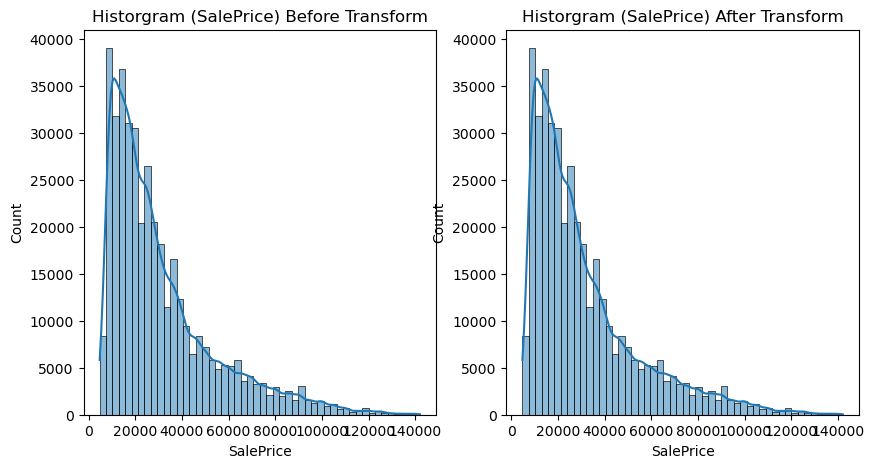

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5), sharex = False)

sns.histplot(train_data.SalePrice, kde = True, bins = 50, ax = ax[0])
ax[0].title.set_text('Historgram (SalePrice) Before Transform')
sns.histplot(train_df.SalePrice, kde = True, bins = 50, ax = ax[1])              
ax[1].title.set_text('Historgram (SalePrice) After Transform');

### Train - Validation Split

In [28]:
X, y = train_df.drop('SalePrice', axis = 1), train_df.SalePrice
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20)

### Hyperparameter Tuning for `RandomForestRegressor`

In [29]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'log2'],
    'max_samples': [10000]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions = param_grid,
                              cv = 5,
                              n_iter = 100,
                              verbose = True
                             )

rs_model.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 16min 43s
Wall time: 19min 2s


In [30]:
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

### Evaluate the randomized model

In [31]:
scores = regression_scores_from_model(rs_model, X_train, y_train, X_val, y_val)
scores

{'Training MAE': 5899.674014751508,
 'Validation MAE': 6038.724948871902,
 'Training RMSLE': 0.2696716009214912,
 'Validation RMSLE': 0.27372412471257695,
 'Training R^2': 0.8441841365688003,
 'Validation R^2': 0.8389509739601098}

### Load and preprocess the Validation dataset
The **validation set** includes all data in 2012. According to [Dataset Description](https://www.kaggle.com/c/bluebook-for-bulldozers/data?select=Data+Dictionary.xlsx):

* **Valid.csv** is the validation set, which contains data from **January 1, 2012 - April 30, 2012** You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

In [32]:
valid_data = pd.read_csv('../resources/data/bulldozers/Valid.csv', parse_dates = ['saledate'], low_memory = False)

In [33]:
print(valid_data.shape)
valid_data.head()

(11573, 52)


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1222837,902859,1376,121,3,1000,0.0,NaN,2012-01-05,375L,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
1,1222839,1048320,36526,121,3,2006,4412.0,Medium,2012-01-05,TX300LC2,...,None or Unspecified,"12' 4""",None or Unspecified,Yes,Double,NaN,NaN,NaN,NaN,NaN
2,1222841,999308,4587,121,3,2000,10127.0,Medium,2012-01-05,270LC,...,None or Unspecified,"12' 4""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1222843,1062425,1954,121,3,1000,4682.0,Low,2012-01-05,892DLC,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,1222845,1032841,4701,121,3,2002,8150.0,Medium,2012-01-04,544H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [34]:
valid_df = preprocess_data(valid_data)

In [35]:
valid_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1222837,902859,1376,121,3,1000,0.0,0,294,122,...,1,1,1,1,1,2012,1,5,3,5
1,1222839,1048320,36526,121,3,2006,4412.0,3,1612,728,...,1,1,1,1,1,2012,1,5,3,5
2,1222841,999308,4587,121,3,2000,10127.0,3,161,75,...,1,1,1,1,1,2012,1,5,3,5
3,1222843,1062425,1954,121,3,1000,4682.0,2,687,248,...,1,1,1,1,1,2012,1,5,3,5
4,1222845,1032841,4701,121,3,2002,8150.0,3,398,156,...,1,1,1,0,0,2012,1,4,2,4


In [37]:
valid_df.shape, train_df.shape

((11573, 108), (401125, 110))

In [38]:
set(list(train_df)) - set(list(valid_df))

{'SalePrice', 'SalePrice_is_missing'}

In [39]:
idx = list(valid_df).index('MachineID_is_missing')
valid_df.insert(idx, 'SalePrice_is_missing', [0] * len(valid_df))

In [40]:
valid_df.shape

(11573, 109)

### Training a model using best hyperparameters

In [44]:
rf_reg_model_1 = RandomForestRegressor(n_estimators = 70,
                                     min_samples_leaf = 3,
                                     min_samples_split = 8,
                                     max_features = 0.5,
                                     n_jobs = -1
                                    )

rf_reg_model_1.fit(X_train, y_train);

## Scoring the model
### Root Mean Squared Log Error (RMSLE)
**RMSLE** is the evaluation metric for this project as stated in the Dataset Description on Kaggle.
* **RMSLE** is non-negative floating point value (the best value is 0.0),  
* or an array of floating point values, one for each individual target.

In [45]:
scores = regression_scores_from_model(rf_reg_model_1, X_train, y_train, X_val, y_val)
scores

{'Training MAE': 2755.663988841703,
 'Validation MAE': 4420.6705018208995,
 'Training RMSLE': 0.13858082178019596,
 'Validation RMSLE': 0.21162737517863744,
 'Training R^2': 0.9619830137389823,
 'Validation R^2': 0.907592410274837}

### Predictions on the Validation dataset

In [46]:
y_preds_valid = rf_reg_model_1.predict(valid_df)

In [47]:
y_preds_valid

array([31554.05462593, 72435.53404928, 35397.50828537, ...,
       14237.19499746, 15212.77705429, 19388.70017879])

### Visualizing the residues
The residues of regression model should be **normally distributed**.

In [104]:
y_preds_val = rf_reg_model_1.predict(X_val)

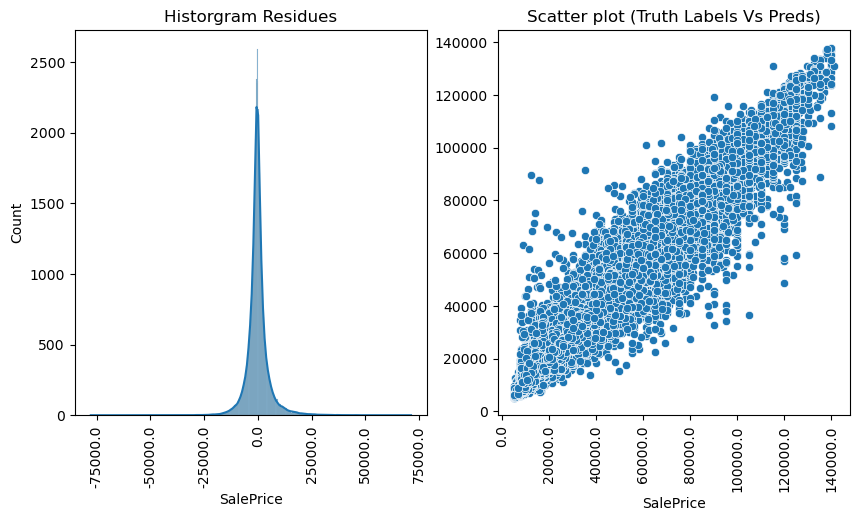

In [119]:
residues = y_val - y_preds_val 

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
sns.histplot(residues, kde = True, ax = ax[0])
ax[0].title.set_text('Historgram Residues')
ax[0].set_xticklabels(ax[0].get_xticks(), rotation = 90)
sns.scatterplot(x = y_val, y = y_preds_val,  ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticks(), rotation = 90)
ax[1].title.set_text('Scatter plot (Truth Labels Vs Preds)');

### Testing the model (`rf_reg_model_1`) using the test dataset provided
* **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition

In [49]:
df_test = pd.read_csv('../resources/data/bulldozers/Test.csv', parse_dates = ['saledate'], low_memory = False)
print(df_test.shape)
df_test.head()

(12457, 52)


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


#### Process Test data

In [50]:
test_df = preprocess_data(df_test)

In [51]:
print(test_df.shape)
test_df.head()

(12457, 108)


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,1,1,1,1,1,2012,5,3,3,124
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,1,1,1,0,0,2012,5,10,3,131
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,1,1,1,1,1,2012,5,10,3,131
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,1,1,1,1,1,2012,5,10,3,131
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,0,0,0,1,1,2012,5,10,3,131


In [52]:
z = test_df.isnull().sum()
print(z[z > 0])

Series([], dtype: int64)


### Evaluating the model using preprocessed test dataset

In [57]:
set(list(X_train)) - set(list(test_df))      # find the missing column

{'SalePrice_is_missing'}

**The column `auctioneerID` has NO missing! As a result the preprocessed test dataset is missing `auctioneerID_is_missing` column. We can add this with all values `0`.**

In [59]:
#list(X_train)

In [60]:
#list(test_df)

In [58]:
idx = list(test_df).index('MachineID_is_missing')
test_df.insert(idx, 'SalePrice_is_missing', [0]*len(test_df))
test_df.shape

(12457, 109)

In [61]:
%%time
y_preds_test = rf_reg_model_1.predict(test_df)

CPU times: total: 188 ms
Wall time: 120 ms


In [62]:
y_preds_test

array([17600.42662694, 16529.48954815, 51707.11484477, ...,
       12451.55124241, 17281.03529824, 26699.45740529])

In [63]:
len(y_preds_test)

12457

### Formatting the results as indicated by Kaggle
https://www.kaggle.com/c/bluebook-for-bulldozers/overview 

* Have a header: "SalesID,SalePrice"
* Contain two columns
    * **SalesID**: SalesID for the validation set in sorted order
    * **SalePrice**: Your predicted price of the sale

In [64]:
df_results = pd.DataFrame()
df_results['SalesID'] = test_df.SalesID
df_results['SalePrice'] = y_preds_test
df_results.head()

,SalesID,SalePrice
0,1227829,17600.426627
1,1227844,16529.489548
2,1227847,51707.114845
3,1227848,68350.422954
4,1227863,52660.506920


### Save results as `.csv`

In [65]:
df_results.to_csv('./model_preds/bulldozers_price_predictions_2.csv', index = False)

### Persisting the model

In [103]:
joblib.dump(rf_reg_model_1, './model_preds/rf_reg_bulldozers_price_prediction_model_best.joblib');

### Feature Importance

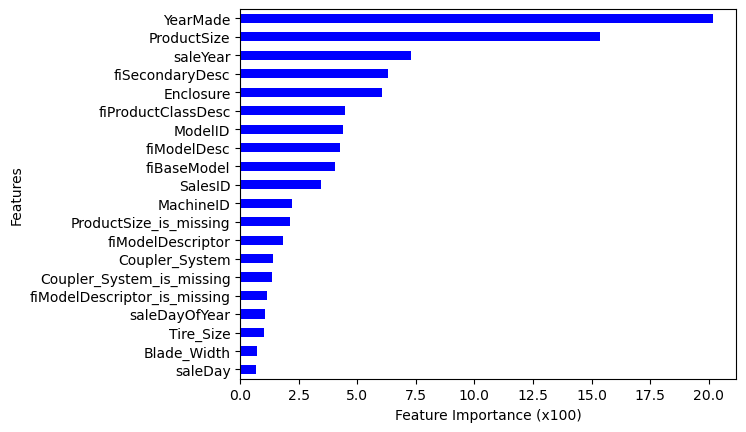

In [67]:
fig = plot_feature_importance(rf_reg_model_1, X_train, 20)

### Feature Selection using `PCA`
The model would certain not live with a whopping **109 features**! To reduce the effect known as the ***curse of dimensionality*** I used **PCA** to generate **25 features** from the **109**. The result is a **drastic reduction in training time to under 3 minutes** (on my laptop) with a comparable RMSLE. There is always a trade-off in efficiency or whatever evaluation metrics because **PCA always involves some loss in information**.

In [81]:
X_train.shape, X_val.shape

((320900, 109), (80225, 109))

In [93]:
pca = PCA(n_components = 25, svd_solver = 'full')
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_valid_pca = pca.transform(valid_df)
X_test_pca = pca.transform(test_df)

In [94]:
%%time
rf_reg_pca = RandomForestRegressor(n_estimators = 70,
                                     min_samples_leaf = 3,
                                     min_samples_split = 8,
                                     max_features = 0.5,
                                     n_jobs = -1
                                    )

rf_reg_pca.fit(X_train_pca, y_train);

CPU times: total: 14min 56s
Wall time: 2min 5s


In [95]:
scores_pca = regression_scores_from_model(rf_reg_pca, X_train_pca, y_train, X_val_pca, y_val)
scores_pca

{'Training MAE': 3164.2608642181863,
 'Validation MAE': 5883.631843060221,
 'Training RMSLE': 0.15860726091696453,
 'Validation RMSLE': 0.2720977227896572,
 'Training R^2': 0.9503672292424992,
 'Validation R^2': 0.8393739077684095}

### Prediction using the test dataset

In [96]:
y_preds_test_pca = rf_reg_pca.predict(X_test_pca)
y_preds_test_pca

array([14826.8001443 , 16738.45924215, 33304.33126397, ...,
       43211.96758599, 48763.4841829 , 47947.73645048])

### Presenting the results as required by Kaggle

In [97]:
df_results = pd.DataFrame()
df_results['SalesID'] = test_df.SalesID
df_results['SalePrice'] = y_preds_test_pca
df_results.head()

,SalesID,SalePrice
0,1227829,14826.800144
1,1227844,16738.459242
2,1227847,33304.331264
3,1227848,31548.617563
4,1227863,30622.385898


In [98]:
df_results.to_csv('./model_preds/bulldozers_price_predictions_pca.csv', index = False)

In [102]:
joblib.dump(rf_reg_pca, './model_preds/rf_reg_bulldozers_price_prediction_model_pca.joblib');